<a href="https://colab.research.google.com/github/CSteinhardt153/CSteinhardt153/blob/main/basic_input_integration_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Free GPU to run the code below:

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()
#!cat /proc/meminfo

'/device:GPU:0'

# Getting Diretory Set up

In [4]:
!pip install ipympl



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.2 MB/s eta 0:00:00


In [5]:
#Setting up all the needed widgets/imports:
%reset -f
#%load_ext autoreload 
#reimport modules when newer version 
#%autoreload 2 
#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%matplotlib widget 
#loads of interactive graphing features

In [6]:

import numpy as np
import numpy.random as npr
import random
np.set_printoptions(linewidth=300)

import scipy as sp

import matplotlib
from matplotlib import pyplot as plt

from time import time

import torch
torch.set_printoptions(linewidth=200)
import torch.nn as nn

from google.colab import output
output.enable_custom_widget_manager() 
#interactive widgets too!

# Create the cochlear frequency map

### inputs in this test case are a variety of different frequencies pulses running across the system.
### cochlear frequency spacing by Greenwood equation: https://en.wikipedia.org/wiki/Greenwood_function#:~:text=According%20to%20Greenwood's%20paper%2C%20a,x%20is%20calculated%20in%20mm.

<p> A is a scaling constant between the characteristic frequency and the upper frequency limit of the species <br>
<p> a is the slope of the straight-line portion of the frequency-position curve, which has shown to be conserved throughout all investigated species after scaling the length of the cochlea <br>
<p> x is the fractional length along the cochlear spiral measured from the apical end of the cochlea to the region of interest. 0 < x < 1. <br>
<p> K is a constant of integration that represents the divergence from the log nature of the curve and is determined by the lower frequency audible limit in the species. <br>

In [7]:
#Greenwood equation:
#make your cochlear fiber frequency spacing
A = 165.4; a = 2.1; k = 0.88;
n_fibers = 20
x = np.linspace(0,1,n_fibers)
freq = np.round(A*(10**(a*x) - k),1)


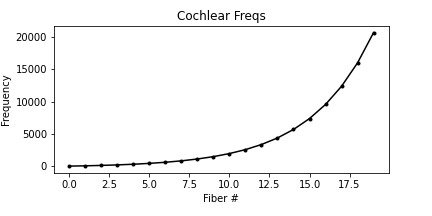

In [8]:
#visualize the cochlear spacing:
fig,ax = plt.subplots(figsize=(6,3))
plt.subplots_adjust(bottom=0.2)
#ax_box = plt.axes([0.1, 0.1, .8,.9])

#fig=plt.figure()
#ax = fig.add_axes([0,0,n_fibers,max(freq)])
plt.plot(np.arange(n_fibers), freq,'k.-') #, 'k')
plt.xlabel('Fiber #')
plt.ylabel('Frequency')
plt.title('Cochlear Freqs')
plt.show()

# Inputs to Model

In [9]:
#Get device to a GPU!
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [22]:
#Make inputs
dt = .1  # in tau
stim_dt = 2 #after how many dt stim value changes
stim_len = 1
sigma = .1 #task diffiuclty
biases = [-1, -.5, -.25, 0, .25, .5, 1]


#Separate into high/low frequencies
category_divide = (np.arange(n_fibers) < n_fibers //2)
f_h = freq[~category_divide] #high freq
f_l = freq[category_divide] #low freq

b = biases[5]
if b < 0:
  #print(b)
  n_bias_freq = round(abs(b)*n_fibers/2)
  freq_choice= np.concatenate((np.random.choice(range(0,10),n_bias_freq,replace = False),
  np.random.choice(range(10,20),round(n_fibers/2 - n_bias_freq),replace = False)),axis =0)
else:
  #print(b)
  n_bias_freq = round(abs(b)*n_fibers/2)
  freq_choice = np.concatenate((np.random.choice(range(0,10),round(n_fibers/2 - n_bias_freq),replace = False),
  np.random.choice(range(10,20),n_bias_freq,replace = False)),axis =0)
#print(freq_choice)

n_f_reps = 2 #2 reps per sample
freq_burst_ord = np.random.choice(freq_choice,round(n_fibers/2), replace = False)
for n in range(n_f_reps):
  cur_sample = np.random.choice(freq_choice,round(n_fibers/2), replace = False)
  freq_burst_ord = np.concatenate((freq_burst_ord,cur_sample))
#print(freq_burst_ord.shape[0])

t = (freq_burst_ord.shape[0]*stim_dt)  # Time in time
T = t / dt #n steps
#print(t,T)
stim_in= np.zeros((n_fibers,round(T)))

for n_f in range(freq_burst_ord.shape[0]):
  #print(n_f,freq_burst_ord[n_f],n_f*stim_dt/dt)
  #print(np.ones((1,round(stim_len/dt))).shape)
  stim_in[freq_burst_ord[n_f],round(n_f*stim_dt/dt):round(n_f*stim_dt/dt + stim_len/dt)] = np.ones((1,round(stim_len/dt)))
print(stim_in.shape)


(20, 600)


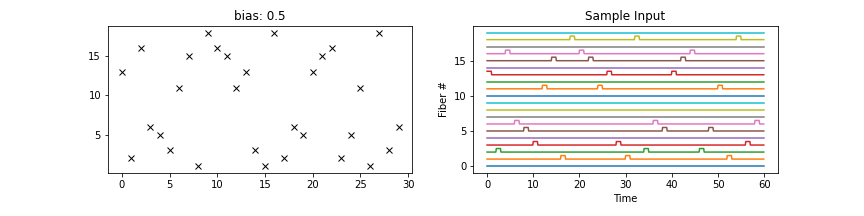

In [26]:
#visualize the cochlear spacing:
fig,ax = plt.subplots(1,2,figsize=(12,3))
plt.subplots_adjust(bottom=0.2)
#ax_box = plt.axes([0.1, 0.1, .8,.9])

#fig=plt.figure()
#ax = fig.add_axes([0,0,n_fibers,max(freq)])
ax[0].plot(np.arange(freq_burst_ord.shape[0]), freq_burst_ord,'kx') #, 'k')
plt.ylabel('Fiber #')
plt.xlabel('Time')
plt.title('Sample Input')

time_scale = np.arange(0,t,dt)
#print(time_scale.shape,stim_in.shape)
for f in range(n_fibers):
  ax[1].plot(time_scale,.5*stim_in[f,:]+f)

ax[0].set_title(f'bias: {b}')
plt.show()


In [ ]:
def stimulus_batch(S, sigma, inorder=False):
  out = []
  y = []
  for s in range(S):
    idx = s % len(biases) if inorder else npr.randint(len(biases))
    b = biases[idx]
    y.append(idx >= len(biases) // 2)
    #print(idx,biases,idx >= len(biases) // 2)
#     print(t,stim_dt, npr.normal(b, sigma,(round(t / stim_dt), 1)).shape)
#     print(stim_dt, dt,np.ones(round(stim_dt / dt)).shape)
#     print((npr.normal(b, sigma, (round(t / stim_dt), 1)) * np.ones(round(stim_dt / dt))).flatten().shape)
    out.append((npr.normal(b, sigma, (round(t / stim_dt), 1)) * np.ones(round(stim_dt / dt))).flatten())
  return torch.tensor(np.stack(out), device = "cuda", dtype=torch.float32), torch.tensor(y, device = "cuda", dtype=torch.float32)

torch.Size([8, 1000]) torch.Size([8])


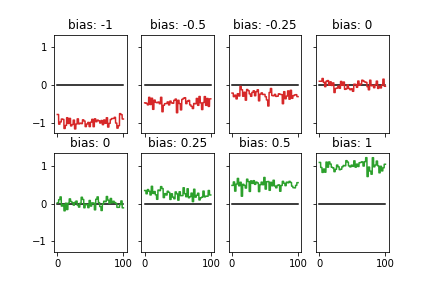

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)
axes = axes.flatten()
sigma= .1
X, Y = stimulus_batch(len(biases), sigma,inorder=True)
X_c =X.cpu()
Y_c =Y.cpu()
print(X_c.shape,Y_c.shape)
for x, y, b, a in zip(X_c, Y_c, biases, axes):
  a.plot([0, t], [0, 0], 'k')
  a.plot(ts, x, color='tab:red' if y == 0 else 'tab:green')
  a.set_title(f'bias: {b}')

# Network Model

In [ ]:
N=50 #neurons in RNN for detecting 

class CTRNN(nn.Module):

  def __init__(self, N, dt,device):
    super().__init__()
    self.dt = dt
    self.N = N
    self.rnn = nn.Linear(N, N, bias=False)
    self.input = nn.Linear(1, N)
    self.output = nn.Linear(N, 1)
    self.act = nn.Tanh()
    self.device = device

  def forward(self, X):
    h = torch.zeros(self.N,device = self.device)
    #print(h.device,X,device)
    Y = []
    X = X.transpose(0, 1)

    #print('xh', self.input(X[0,1]).shape)
    for x in X:
      #print('x+in',x.shape)#self.input(x))
      #print('x_trans_in',self.input(torch.unsqueeze(x,1)).shape)
      #print('hh*h',self.rnn(h).shape)
      #tmp = self.act(self.rnn(h) + self.input(torch.unsqueeze(x,1)))
      #print('act_out',tmp.shape)
      #print(self.rnn(h).device)
      h = h * (1 - self.dt) + self.dt * self.act(self.rnn(h) + self.input(torch.unsqueeze(x,1)))#self.input(x))
      tmp =self.output(h)
      #print('h_out',tmp.device)
      Y.append((self.output(h)))
    Y = torch.stack(Y).transpose(1, 0)
    #print(Y.device)
    #print('Y',Y.shape)
    return Y


# Train Network

In [ ]:
#Demo messing around:
S = 10
inp, out = stimulus_batch(S,sigma=0.1)
#print(device,inp.is_cuda)
#print(inp.shape,inp[1][None,...][:,-1].shape,out.shape)
c = CTRNN(N,dt,device)
c.to(device)
c.forward(inp).shape

torch.Size([10, 1000, 1])

epoch: 0, loss: 7.688e-01, accuracy: 0.516
epoch: 25, loss: 7.471e-01, accuracy: 0.445
epoch: 50, loss: 6.959e-01, accuracy: 0.477
epoch: 75, loss: 6.533e-01, accuracy: 0.461
epoch: 100, loss: 6.140e-01, accuracy: 0.750
epoch: 125, loss: 5.821e-01, accuracy: 0.797
epoch: 150, loss: 5.191e-01, accuracy: 0.867
epoch: 175, loss: 4.538e-01, accuracy: 0.883
epoch: 200, loss: 4.254e-01, accuracy: 0.844
epoch: 225, loss: 3.711e-01, accuracy: 0.914
epoch: 250, loss: 3.473e-01, accuracy: 0.867
epoch: 275, loss: 2.839e-01, accuracy: 0.891
epoch: 300, loss: 2.880e-01, accuracy: 0.875
epoch: 325, loss: 2.926e-01, accuracy: 0.867
epoch: 350, loss: 2.820e-01, accuracy: 0.875
epoch: 375, loss: 2.508e-01, accuracy: 0.898
epoch: 400, loss: 2.153e-01, accuracy: 0.898
epoch: 425, loss: 2.287e-01, accuracy: 0.914
epoch: 450, loss: 2.299e-01, accuracy: 0.891
epoch: 475, loss: 2.155e-01, accuracy: 0.898
epoch: 500, loss: 2.443e-01, accuracy: 0.898
epoch: 525, loss: 2.328e-01, accuracy: 0.883
epoch: 550, los

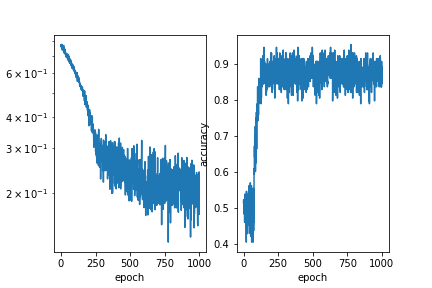

In [ ]:
fig, axes = plt.subplots(1, 2)

epochs = 1000 #000
lr = 1e-4
rnn = CTRNN(N, dt,device)
rnn.to(device)

loss_fx = nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(rnn.parameters(), lr=lr)
batch_size = 128
sig = nn.Sigmoid()
losses = []
accs = []

st = time()
for e in range(epochs + 1):
  opt.zero_grad()
  x, y = stimulus_batch(batch_size,sigma)
  x = x.to(device)
  y = y.to(device)
  #print(x.is_cuda,y.is_cuda)
  #print(x.shape,y.shape)
  logits = rnn(x[..., None])[:, -1, 0]
  #print(logits.is_cuda)
  y_comp =torch.unsqueeze(y,1)
  #print('logit',logits.shape,y_comp.shape,(sig(logits.detach()) > .5).transpose(0,1))
  #print(y)
  #print('acc:',((sig(logits.detach()) > .5) == y_comp))
  #print('acc:',((sig(logits.detach()) > .5) == y_comp).to(torch.float32).mean())
  acc = ((sig(logits.detach()) > .5).transpose(0,1) == y).to(torch.float32).mean().to('cpu')
  loss = loss_fx(logits, y_comp)
  losses.append(loss.to('cpu').item())
  accs.append(acc)
  if e % 25 == 0:
    print(f'epoch: {e}, loss: {loss:.3e}, accuracy: {acc:.3f}')
    axes[0].cla()
    axes[0].semilogy(losses)
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[1].cla()
    axes[1].plot(accs)
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    fig.canvas.draw()
    fig.canvas.flush_events()

  if e < epochs:
    loss.backward()
    opt.step()

et = time()  
print('Run time: ',et-st, ' s')